# PROJET 6 : DÉTECTEZ DE FAUX BILLETS

## PRÉALABLES :

### A - Importation des librairies :

In [1]:
# Importation des librairies :
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, decomposition
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### B - Importation des fichiers :

In [2]:
notes = pd.read_csv("notes.csv")
notes.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


### C - Définition des fonctions :

#### 1 - Cercle des corrélations :

In [3]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

#### 2 - Éboulis des valeurs propres :

In [4]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

### D - Vérification des données :

#### 1 - Colonnes booléennes :

In [5]:
# Vérification de la colonne "is_genuine" :
# notes.is_genuine.unique()

#### 2 - Colonnes numériques :

In [6]:
# Vérification des 6 autres colonnes :
# notes.sort_values(by="diagonal")
# notes.sort_values(by="height_left")
# notes.sort_values(by="height_right")
# notes.sort_values(by="margin_low")
# notes.sort_values(by="margin_up")
# notes.sort_values(by="length")

#### 3 - Valeurs aberrantes ?

## MISSION 0 : description des données

###  A - Mesures de tendance centrale :

#### 1 - Tendances globales :

In [7]:
# Description :
notes.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


#### 2 - Tendances "Billets authentiques" :

In [8]:
notesTrue = notes[notes["is_genuine"]==True]
notesTrue.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200
std,0.307981,0.296251,0.292406,0.314509,0.197726,0.380476
min,171.040000,103.230000,103.140000,3.540000,2.270000,111.760000
25%,171.790000,103.740000,103.557500,3.900000,2.937500,112.995000
50%,172.005000,103.915000,103.760000,4.080000,3.070000,113.210000
75%,172.162500,104.145000,103.972500,4.382500,3.192500,113.505000
max,172.750000,104.860000,104.950000,5.040000,3.530000,113.980000


#### 3 - Tendances "Faux billets" :

In [9]:
notesFalse = notes[notes["is_genuine"]==False]
notesFalse.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
std,0.297426,0.213130,0.253152,0.540846,0.185102,0.676931
min,171.380000,103.780000,103.440000,3.820000,2.980000,109.970000
25%,171.682500,104.082500,103.982500,4.952500,3.185000,111.270000
50%,171.875000,104.215000,104.170000,5.265000,3.335000,111.765000
75%,172.047500,104.377500,104.280000,5.702500,3.450000,111.985000
max,173.010000,104.720000,104.860000,6.280000,3.680000,113.640000


#### 4 - Corrélations entre les variables :

In [10]:
notes.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.139223,-0.461730,-0.551309,-0.800111,-0.582801,0.825743
diagonal,0.139223,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,-0.461730,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,-0.551309,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.800111,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.582801,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
length,0.825743,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


###  B - Comparaison des mesures entre vrais et faux billets :

#### 1 - Mesure de la diagonale :

Text(0, 0.5, 'Vrais ou faux billets')

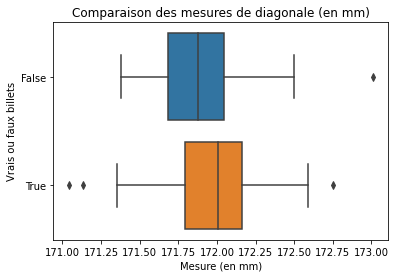

In [11]:
# Comparaisons des diagonales entre vrais et faux billets :
sns.boxplot(x=notes["diagonal"], y=notes["is_genuine"], orient="h")
plt.title("Comparaison des mesures de diagonale (en mm)")
plt.xlabel("Mesure (en mm)")
plt.ylabel("Vrais ou faux billets")

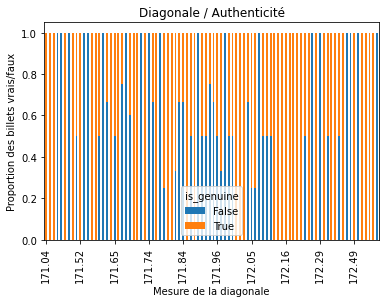

In [12]:
table= pd.crosstab(notes.diagonal,notes.is_genuine)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Diagonale / Authenticité')
plt.xlabel('Mesure de la diagonale')
plt.ylabel('Proportion des billets vrais/faux')
plt.locator_params(axis="x", nbins=10, tight=True)

#### 2 - Mesure de la hauteur du billet sur la gauche :

Text(0, 0.5, 'Vrais ou faux billets')

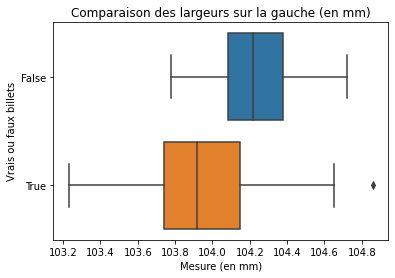

In [13]:
# Comparaisons des largeurs sur la gauche entre vrais et faux billets :
sns.boxplot(x=notes["height_left"], y=notes["is_genuine"], orient="h")
plt.title("Comparaison des largeurs sur la gauche (en mm)")
plt.xlabel("Mesure (en mm)")
plt.ylabel("Vrais ou faux billets")

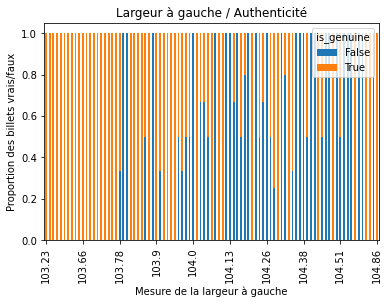

In [14]:
table= pd.crosstab(notes.height_left,notes.is_genuine)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Largeur à gauche / Authenticité')
plt.xlabel('Mesure de la largeur à gauche')
plt.ylabel('Proportion des billets vrais/faux')
plt.locator_params(axis="x", nbins=10, tight=True)

#### 3 - Comparaison des hauteurs sur la droite entre vrais et faux billets :

Text(0, 0.5, 'Vrais ou faux billets')

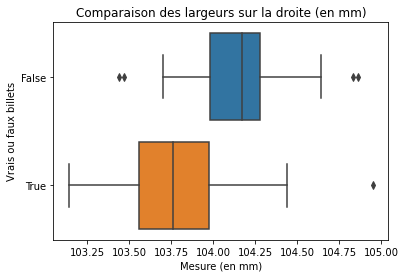

In [15]:
# Comparaisons des largeurs sur la droite entre vrais et faux billets :
sns.boxplot(x=notes["height_right"], y=notes["is_genuine"], orient="h")
plt.title("Comparaison des largeurs sur la droite (en mm)")
plt.xlabel("Mesure (en mm)")
plt.ylabel("Vrais ou faux billets")

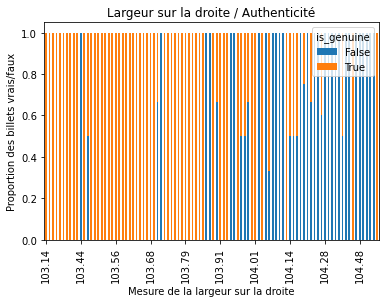

In [16]:
table= pd.crosstab(notes.height_right,notes.is_genuine)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Largeur sur la droite / Authenticité')
plt.xlabel('Mesure de la largeur sur la droite')
plt.ylabel('Proportion des billets vrais/faux')
plt.locator_params(axis="x", nbins=10, tight=True)

#### 4 - Comparaison des marges inférieures entre vrais et faux billets :

Text(0, 0.5, 'Vrais ou faux billets')

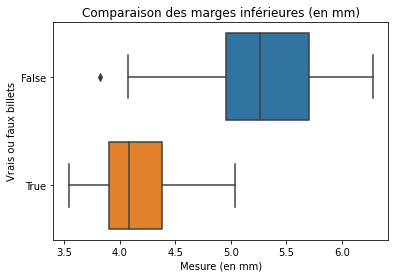

In [17]:
# Comparaisons des marges inférieures entre vrais et faux billets :
sns.boxplot(x=notes["margin_low"], y=notes["is_genuine"], orient="h")
plt.title("Comparaison des marges inférieures (en mm)")
plt.xlabel("Mesure (en mm)")
plt.ylabel("Vrais ou faux billets")

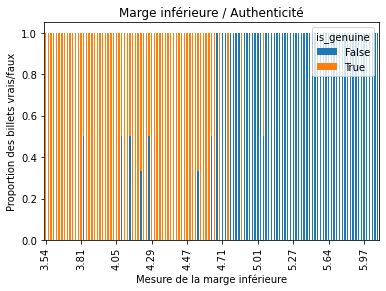

In [18]:
table= pd.crosstab(notes.margin_low,notes.is_genuine)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Marge inférieure / Authenticité')
plt.xlabel('Mesure de la marge inférieure')
plt.ylabel('Proportion des billets vrais/faux')
plt.locator_params(axis="x", nbins=10, tight=True)

#### 5 - Comparaison des marges supérieures entre vrais et faux billets :

Text(0, 0.5, 'Vrais ou faux billets')

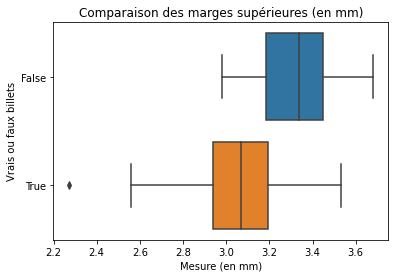

In [19]:
# Comparaisons des marges supérieures entre vrais et faux billets :
sns.boxplot(x=notes["margin_up"], y=notes["is_genuine"], orient="h")
plt.title("Comparaison des marges supérieures (en mm)")
plt.xlabel("Mesure (en mm)")
plt.ylabel("Vrais ou faux billets")

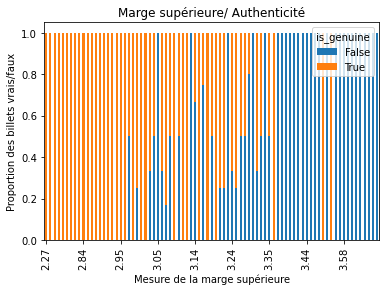

In [20]:
table= pd.crosstab(notes.margin_up,notes.is_genuine)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Marge supérieure/ Authenticité')
plt.xlabel('Mesure de la marge supérieure')
plt.ylabel('Proportion des billets vrais/faux')
plt.locator_params(axis="x", nbins=10, tight=True)

#### 6 - Comparaison de la longueur des billets (vrais et faux) :

Text(0, 0.5, 'Vrais ou faux billets')

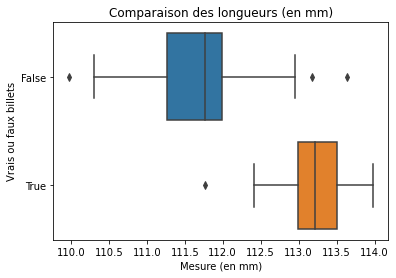

In [21]:
# Comparaisons des longueurs entre vrais et faux billets :
sns.boxplot(x=notes["length"], y=notes["is_genuine"], orient="h")
plt.title("Comparaison des longueurs (en mm)")
plt.xlabel("Mesure (en mm)")
plt.ylabel("Vrais ou faux billets")

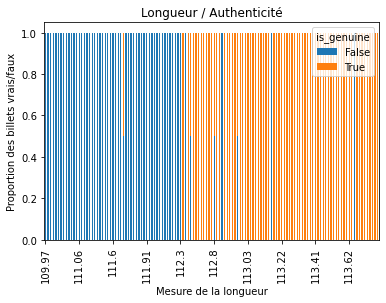

In [22]:
table= pd.crosstab(notes.length,notes.is_genuine)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Longueur / Authenticité')
plt.xlabel('Mesure de la longueur')
plt.ylabel('Proportion des billets vrais/faux')
plt.locator_params(axis="x", nbins=10, tight=True)

#### 7 - Conclusion :

## MISSION 1 : analyse en composantes principales : 

### A - Préparation des données :

#### 1 - Définitions :

In [23]:
# Définitions :
notesAED = notes.set_index("is_genuine")
X = notesAED.values
diagnostic = notesAED.index

#### 2 - Centrage et réduction

In [24]:
# Centrage et réduction :
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [25]:
# Vérification des moyennes :
np.mean(X_scaled, axis=0)

array([ 7.69580478e-15,  3.14728635e-14,  3.61958829e-14,  7.52339367e-16,
       -1.50467873e-15, -1.37510918e-14])

In [26]:
# Vérification des écarts-type :
np.std(X_scaled, axis=0, ddof=0)

array([1., 1., 1., 1., 1., 1.])

### B - Éboulis des valeurs propres :

#### 1 - Calcul des composantes principales :

In [27]:
# Calculs :
n_comp = 6
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=6)

#### 2 - Affichage de l'éboulis des valeurs propres :

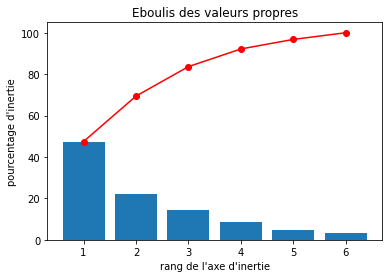

In [28]:
# Visualisation :
display_scree_plot(pca)

### C - Cercle des corrélations :

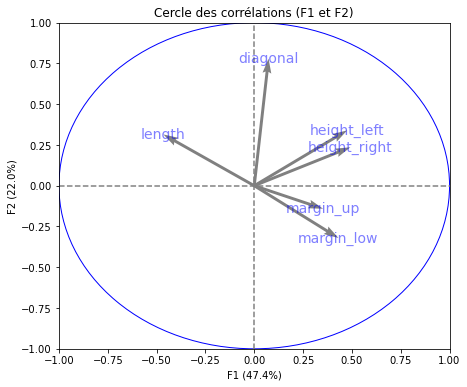

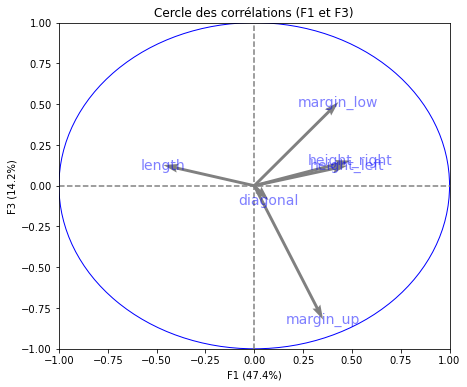

In [29]:
# Cercles des corrélations
pcs = pca.components_
labelsVariables = notesAED.columns
display_circles(pcs, 3, pca,[(0,1),(0,2)],labels = np.array(labelsVariables))

### D - Projections des individus dans le plan factoriel :

#### 1 - Calcul de la projection :

In [30]:
# Calculs :
pca = decomposition.PCA().fit(X_scaled)
Z_projected = pca.transform(X_scaled)

#### 2 - Visualisation de la projection :

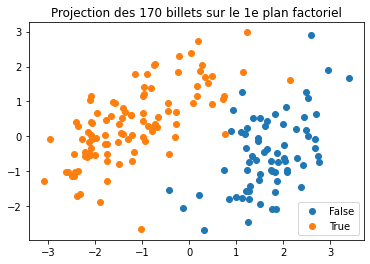

In [31]:
# Visualisation de la projection F1/F2 :
label = diagnostic
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(Z_projected[label == i , 0] , Z_projected[label == i , 1] , label = i)
plt.legend(loc="lower right")
plt.title("Projection des {} billets sur le 1e plan factoriel".format(Z_projected.shape[0]))
plt.show(block=False)

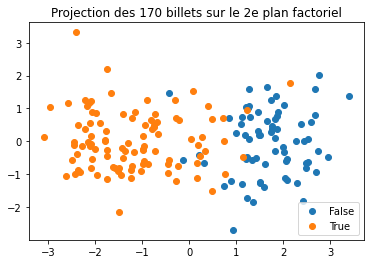

In [32]:
# Visualisation de la projection F1/F3 :
label = diagnostic
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(Z_projected[label == i , 0] , Z_projected[label == i , 2] , label = i)
plt.legend(loc="lower right")
plt.title("Projection des {} billets sur le 2e plan factoriel".format(Z_projected.shape[0]))
plt.show(block=False)

#### 3 - Conclusion :

## MISSION 2 : Appliquer un algorithme de classification :

### A - Clustering par K-Means :

#### 1 - K-Means :

In [33]:
# Calculs K-Means :
n_clust = 2
km = KMeans(n_clusters=n_clust)
km.fit(X_scaled)
clustersKM = km.labels_

#### 2 - Projections des clusters KM :

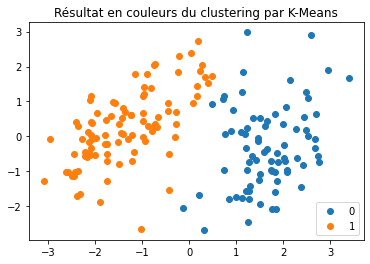

In [34]:
# Affichage projection F1/F2 KM :
label = clustersKM
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(Z_projected[label == i , 0] , Z_projected[label == i , 1] , label = i)
plt.legend(loc="lower right")
plt.title("Résultat en couleurs du clustering par K-Means".format(Z_projected.shape[0]))
plt.show(block=False)

#### 3 - Projection des clusters KM avec le libellé vrai/faux billet :

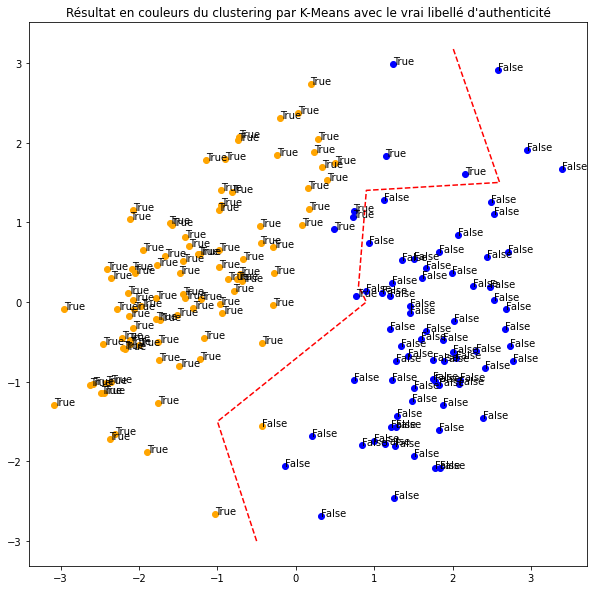

In [35]:
# Projection des billets (avec les couleurs des clusters et les vrais libellés) :
plt.figure(figsize=(10,10))
for couleur,k in zip(['blue','orange'],[0,1]):
    plt.scatter(Z_projected[clustersKM==k,0] , Z_projected[clustersKM==k,1],c=couleur)
    
for i,label in enumerate(notesAED.index):
    plt.annotate(label,(Z_projected[i,0],Z_projected[i,1]))

plt.title("Résultat en couleurs du clustering par K-Means avec le vrai libellé d'authenticité".format(Z_projected.shape[0]))
plt.plot([-0.5, -1, 0.9, 0.8, 0.9, 2.6, 2],[-3, -1.5, 0, 0.2, 1.4, 1.5, 3.2], "r--")
plt.show()

#### 4 - Conclusion :

## MISSION 3 : Modélisation (régression logistique) : 

### A - Préparation des données :

#### 1 - Initialisation de l'algorithme de calcul :

In [36]:
# Algorithme de calcul :
model = LogisticRegression(penalty="none", solver="newton-cg")

#### 2 - Définitions des variables :

In [37]:
# Définitions de X et Y :
y = notes["is_genuine"]
X = notes.drop("is_genuine", axis=1)

#### 3 - Échantillons test et entraînement :

In [38]:
# Création d'échantillon de test et d'entraînement :
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.28, stratify=y)

### B - Modélisation :

#### 1 - Calculs du modèle :

In [39]:
# Calculs du modèle :
model.fit(X_train, Y_train)

LogisticRegression(penalty='none', solver='newton-cg')

#### 2 - Fonction d'application du modèle :

In [40]:
# Définition de la fonction :
def true_or_false(data):
    X_predict = data.loc[:,("diagonal","height_left","height_right","margin_low","margin_up","length")]
    predictResult = model.predict(X_predict)
    proba = model.predict_proba(X_predict)[:,1]
    data["test_result"]=predictResult
    data["is_true_probability"] = proba
    return(data)

#### 3 - Évaluation du modèle à partir de l'échantillon test :

In [41]:
# Score échantillon de test / échantillon d'entraînement :
model.score(X_test, Y_test)

0.9583333333333334

In [42]:
# Préparation et application du modèle sur X_test :
scoreTest = X_test.join(y)
true_or_false(scoreTest)
scoreTest.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,test_result,is_true_probability
127,172.40,104.55,104.22,5.18,3.51,111.94,False,False,2.092531e-24
65,172.16,104.43,104.06,4.51,3.19,112.69,True,True,9.918261e-01
104,171.75,104.16,104.23,5.75,3.25,111.68,False,False,7.424382e-30
81,171.95,103.84,103.68,3.79,3.09,112.68,True,True,1.000000e+00
99,171.81,103.96,103.47,4.00,3.00,113.10,True,True,1.000000e+00


In [43]:
erreursTest = scoreTest[scoreTest["is_genuine"]!=scoreTest["test_result"]]
erreursTest.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine,test_result,is_true_probability
9,172.14,104.34,104.20,4.63,3.02,112.47,True,False,5.447289e-02
69,171.94,104.11,104.16,4.08,3.35,111.76,True,False,1.001717e-07


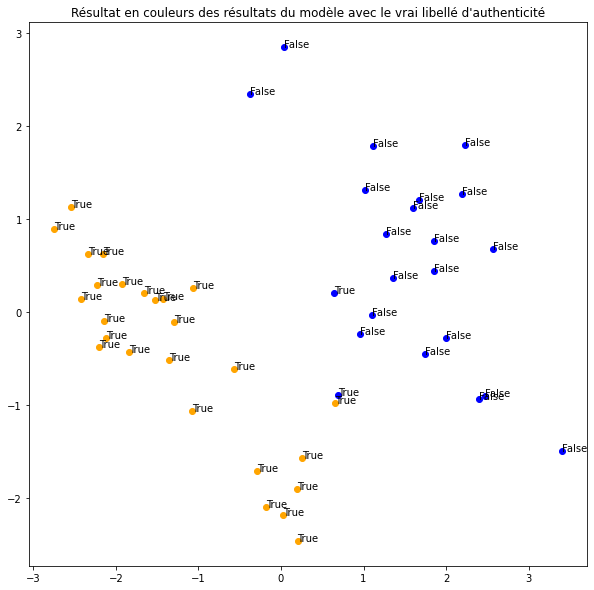

In [44]:
# Visualisation :

# Calculs de la projection :
XT = X_test.values
XT_scaled = std_scale.transform(XT)
pcaT = decomposition.PCA().fit(XT_scaled)
T_projected = pcaT.transform(XT_scaled)

## Projection du test (avec les couleurs du modèle et les vrais libellés) :
plt.figure(figsize=(10,10))
for couleur,k in zip(['blue','orange'],[0,1]):
    plt.scatter(T_projected[scoreTest["test_result"]==k,0] , T_projected[scoreTest["test_result"]==k,1],c=couleur)
for i,label in enumerate(scoreTest["is_genuine"]):
    plt.annotate(label,(T_projected[i,0],T_projected[i,1]))
plt.title("Résultat en couleurs des résultats du modèle avec le vrai libellé d'authenticité".format(T_projected.shape[0]))
plt.show()

### C - test sur le dataframe principal :

#### 1 - Application du modèle sur le dataframe principal :

In [45]:
# Score sur le dataframe principal :
model.score(X,y)

0.9882352941176471

In [46]:
# Aperçu du dataframe principal après application du programme du modèle :
true_or_false(notes).head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,test_result,is_true_probability
0,True,171.81,104.86,104.95,4.52,2.89,112.83,True,0.999997
1,True,171.67,103.74,103.70,4.01,2.87,113.29,True,1.000000
2,True,171.83,103.76,103.76,4.40,2.88,113.84,True,1.000000
3,True,171.80,103.78,103.65,3.73,3.12,113.63,True,1.000000
4,True,172.05,103.70,103.75,5.04,2.27,113.55,True,1.000000


In [47]:
# Différence entre la véritable authenticité des billets et la prédiction :
erreursData = notes[notes["is_genuine"]!=notes["test_result"]]
erreursData

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,test_result,is_true_probability
9,True,172.14,104.34,104.20,4.63,3.02,112.47,False,5.447289e-02
69,True,171.94,104.11,104.16,4.08,3.35,111.76,False,1.001717e-07


#### 2 - Visualisation des résultats :

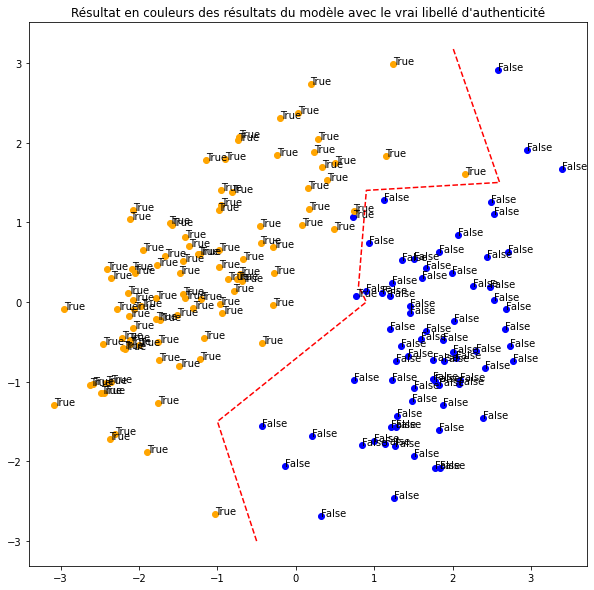

In [48]:
# Projection des billets (avec les couleurs du modèle et les vrais libellés) :
plt.figure(figsize=(10,10))
for couleur,k in zip(['blue','orange'],[0,1]):
    plt.scatter(Z_projected[notes["test_result"] ==k,0] , Z_projected[notes["test_result"] ==k,1],c=couleur)
for i,label in enumerate(notes["is_genuine"]):
    plt.annotate(label,(Z_projected[i,0],Z_projected[i,1]))
plt.plot([-0.5, -1, 0.9, 0.8, 0.9, 2.6, 2],[-3, -1.5, 0, 0.2, 1.4, 1.5, 3.2], "r--")
plt.title("Résultat en couleurs des résultats du modèle avec le vrai libellé d'authenticité".format(Z_projected.shape[0]))
plt.show()

### D - test sur le dataframe exemple :

In [49]:
# Importation du dataframe d'exemple :
exemple = pd.read_csv("example.csv")
exemple

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [50]:
# Application du modèle :
true_or_false(exemple)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,test_result,is_true_probability
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,6.005117e-22
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,6.598466e-29
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,9.444309e-23
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,1.000000e+00
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,1.000000e+00


## Test de la soutenance :

In [51]:
# Importation du dataframe de test :
# test = pd.read_csv(".csv")

In [52]:
# Application du modèle :
# true_or_false(test)